<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [4]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20
deep_num = 3
dropout_prob = 0.2

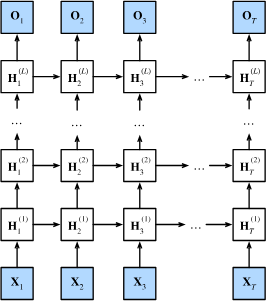

as illustrated by the above graph.
we could define the layers of the rnn as deep_num
and every hidden state is decided by the pre step hidden state and the lower layers hidden state.

let us implement this structure.

In [5]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))
    self.dropout = nn.Dropout(p=dropout_prob)
  def forward(self, x, h):
    h = torch.tanh(self.i2h(x) + self.h2h(h) + self.hb2)
    h = self.dropout(h)
    y = self.h2o(h) + self.ob
    return y, h


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size)
    self.dropout = nn.Dropout(p=dropout_prob)
    self.rnn_list = nn.ModuleList([SimpleRNN(vocab_size, hidden_size) for _ in range(deep_num)])
  def forward(self, x, h_prev_list):
    x = self.embedding(x)
    h_list = []
    h = self.e2h(x)
    for i in range(self.deep_num):
      x, h = self.rnn_list[i](h, h_prev_list[i])
      h = self.dropout(h)
      h_list.append(h)
    return x, h_list

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [6]:
def generateMiniBatch(start_idx):
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [8]:
stopi = []
lossi = []

In [14]:
# Training loop
num_iterations = 2 * 1000000
p = 0
for iteration in range(num_iterations):

  if p + seq_length + 1 > len(data):
    p = 0;

  inputs, targets = generateMiniBatch(p)

  optimizer.zero_grad()

  totalloss = 0
  hprev_list = [torch.zeros(1, 1, hidden_size) for _ in range(deep_num)]  # Reset RNN memory
  for i in range(seq_length):
    input_char = inputs[:,i].unsqueeze(1)
    output_char = targets[:,i]

    predict_char, hprev_list = model(input_char, hprev_list)

    loss = criterion(predict_char.squeeze(1), output_char)
    totalloss += loss.item()

    loss.backward()
    for i in range(deep_num):
      hprev_list[i] = hprev_list[i].detach()

    for param in model.parameters():
      if param.grad is not None:
        param.grad.data.clamp_(-5, 5)

    optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss/seq_length}')
    stopi.append(iteration)
    lossi.append(totalloss/seq_length)

  p += seq_length  # Move data pointer

Iteration 0, Loss: 2.47068058013916
Iteration 1000, Loss: 2.1623160600662232
Iteration 2000, Loss: 2.369984841346741
Iteration 3000, Loss: 2.432487921714783
Iteration 4000, Loss: 1.929606237411499
Iteration 5000, Loss: 2.462399377822876
Iteration 6000, Loss: 2.5350724697113036
Iteration 7000, Loss: 2.18318865776062
Iteration 8000, Loss: 2.4505562210083007
Iteration 9000, Loss: 2.3255577087402344
Iteration 10000, Loss: 2.3953387451171877
Iteration 11000, Loss: 2.624719753265381
Iteration 12000, Loss: 2.6566634941101075
Iteration 13000, Loss: 2.8667912006378176
Iteration 14000, Loss: 2.331308350563049
Iteration 15000, Loss: 2.80323899269104
Iteration 16000, Loss: 2.6609672355651854
Iteration 17000, Loss: 2.050966944694519
Iteration 18000, Loss: 2.1994505310058594
Iteration 19000, Loss: 2.152315926551819
Iteration 20000, Loss: 2.1449512481689452
Iteration 21000, Loss: 2.118380184173584
Iteration 22000, Loss: 2.0837249660491945
Iteration 23000, Loss: 2.1701531457901
Iteration 24000, Loss: 

RuntimeError: stack expects each tensor to be equal size, but got [25] at entry 0 and [24] at entry 19

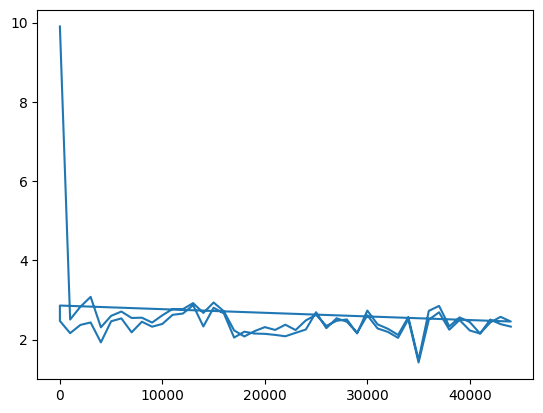

In [15]:
plt.plot(stopi, lossi)

In [16]:
# Sample from the model
def sample(model, seed_ix, n):
  h_list = [torch.zeros(1, hidden_size) for _ in range(deep_num)]
  x = torch.tensor(seed_ix, dtype=torch.long).view(1, 1)
  ixes = []

  for _ in range(n):
    outputs, h_list = model(x, h_list)
    p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    x = torch.tensor(ix, dtype=torch.long).view(1, 1)
    ixes.append(ix)

  return ixes

In [17]:
#the generated text is not as good as expected. so may need further optimize
sample_ix = sample(model, char_to_ix[data[0]], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(f'Generated Text:\n{txt}')

Generated Text:
ario hithes, marenkat to MingellyrsuyI;ASTOO:
Tithe ti aloer-heang ane tomree paxe.
Wheur boon issue.. umeang, Godose and fis
of i siling tet thyt tre, a or wea is he elast tind, brou pvnot art, u ser ake rur,le
shacee,IO:
Yelhessirs ooessthatite whisuithot maynid,
IAhidn,
Dit abey spnol, wetsyau aru, Sy sw youlehv,ThE
A you?
;euc a ycu yeAy yhele wendent?

IaTatiee;
Why thdr.
Whing sulat ass lon orand! hing.

ANIOSEOOTIN: my.
AN:

SEBNout le the buter thavb;ong suspe, walle.

ANTu RLsand een of oat opon.

ANTENIO:
ThOplas D phly,
I sananddongouliwhee, worl;onp

ALOeIOSPdhTOySTIAN:

ANTIAN:
Yor sasees:

ANTI thatas thy neenald?

SEANIO:
Noun
 tot mader ing thatsir;, angonstnoi thaal inrecers, ioon they orrts tha. thotyin we ling tnase calry th:
Toagm ro O, IAANTIANP: mowkss andot andakp

SEing thay mee of, and uis ey afceestheve hh theOAPd:
Ong,
Dor tawl SoONZANALTINIA
That useelestioonge, rrninsex fukatiprd srne in thetay staenydficrandd ser:
Wheeden sto datage:

ANIO: